# Lifetime time correlation functions and hydroxide ions

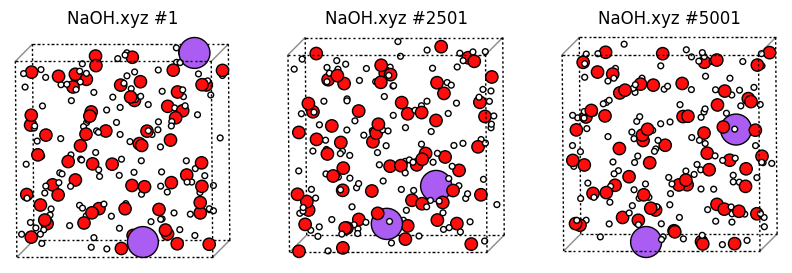

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import plot_trajectory
plot_trajectory("trajectories/NaOH.xyz");


The above trajectory contains two NaOH formula units (Na shown in purple).

## Hydroxide ion definition, show hydroxides in different color

The most robust way of assigning oxygens as either hydroxide or water is to use the ``FINDSHORTEST`` group definition, in order to assign each hydrogen to its nearest oxygen. This is good since we then do not need to worry about interatomic distances, which would be very complicated to handle during proton transfer events (which frequently occur in the trajectory).

``FINDSHORTEST`` will typically ensure that the number of hydroxide ions remains **constant**, which is useful/needed for the time correlation function calculation.

So let's do it and plot hydroxide oxygens as S (yellow). Below we also define groups for hydronium (H3O+) and oxide (O not coordinating any H) - such species do not appear in this trajectory but it's good to have the definition.

In [87]:
%%sh
cat > hydroxide1.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

# Stop analysis after 1000 frames (do not analyze entire trajectory)
MaxTimestep 1000

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup HydroniumO SUBGROUPCN SuperO Coord 3
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1
DefineGroup OxideO DIFF O SuperO
DefineGroup HydroniumH INVERTCOORDINATION HydroniumO
DefineGroup WaterH INVERTCOORDINATION WaterO
DefineGroup HydroxideH INVERTCOORDINATION HydroxideO

PrintGroup All XYZ hydroxide_colored.xyz SPECIAL HydroxideO S
EOF
OMP_NUM_THREADS=1 lionanalysis.exe hydroxide1.config > hydroxide1.out


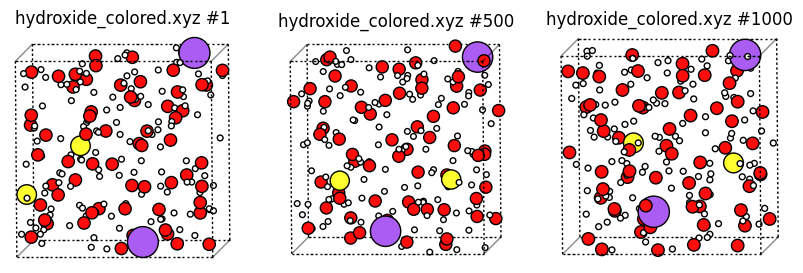

In [88]:
plot_trajectory("hydroxide_colored.xyz");

There appear two be two hydroxide ions (yellow) in each frame, which is what we'd expect. See also the NaOH mean squared displacement notebook for further analysis of this system.


## Lifetime from continuous and intermittent time correlation functions

* Continuous time correlation function treats any fluctuation in the identity of the assigned HydroxideO as a proton transfer event

* Intermittent time correlation function only counts events that continuously last more than some tolerance time ``t*``. Below we set ``t* = 0.3 ps``. There is no rule for the right choice of ``t*``. The larger the value, the longer the calculated lifetime.

For dynamic properties like time correlation functions, you must set the ``BasicTimeUnit`` near the top of the input file to the time between frames in ps. Here the time between frames is 5 fs = 0.005 ps. This also lets you use the ``MaxHistory 10 RealTime`` option to set the maximum correlation time in picoseconds instead of the number of frames.

In [89]:
%%sh
cat > hydroxide2.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup HydroniumO SUBGROUPCN SuperO Coord 3
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1
DefineGroup OxideO DIFF O SuperO
DefineGroup HydroniumH INVERTCOORDINATION HydroniumO
DefineGroup WaterH INVERTCOORDINATION WaterO
DefineGroup HydroxideH INVERTCOORDINATION HydroxideO

# Continuous time correlation function
TResidenceTime \
    ParentGroup O \
    Group HydroxideO \
    Filename continuous_hydroxide_lifetime.txt \
    OldMemberEscape1 0 0 0 UR HydroxideO \
    NewMemberEscape1 -1 0 -1 VR HydroxideO \
    MaxHistory 10 RealTime PrintEvery 2000

# Intermittent time correlation function
# set a tolerance time t* = 0.3 ps on the NewMemberEscape1 line
TResidenceTime \
    ParentGroup O \
    Group HydroxideO \
    Filename intermittent_hydroxide_lifetime.txt \
    OldMemberEscape1 0 0 0 UR HydroxideO \
    NewMemberEscape1 -1 0.3 -1 VR HydroxideO \
    MaxHistory 10 RealTime PrintEvery 2000

EOF
OMP_NUM_THREADS=1 lionanalysis.exe hydroxide2.config > hydroxide2.out


By fitting the decaying time correlation function to a single or double exponential, you can extract the lifetime as the integral of that curve.

Below we demonstrate how to do this for a decaying double exponential with scipy.

In [90]:
!head continuous_hydroxide_lifetime.txt

### DESCR TResidenceTime     ParentGroup O     Group HydroxideO     Filename continuous_hydroxide_lifetime.txt     OldMemberEscape1 0 0 0 UR HydroxideO     NewMemberEscape1 -1 0 -1 VR HydroxideO     MaxHistory 10 RealTime PrintEvery 2000
### count 5001 timeunit 0.005
#t(ps) value sum count
0 1 10002 10002
0.005 0.9774 9774 10000
0.01 0.957992 9578 9998
0.015 0.941477 9411 9996
0.02 0.928357 9278 9994
0.025 0.918135 9174 9992
0.03 0.908609 9077 9990


In [91]:
from scipy.optimize import curve_fit

def double_exp(x, A: float, tau1: float, tau2: float):
    return A*np.exp(-x/tau1) + (1-A)*np.exp(-x/tau2)

def fit_and_plot_double_exp(df: pd.DataFrame, A: float = 0.1, tau1: float = 0.5, tau2: float = 2.5, title: str = "") -> plt.Axes:
    p0 = A, tau1, tau2
    x = df["#t(ps)"].to_numpy()
    y = df["value"].to_numpy()

    popt, _ = curve_fit(double_exp, x, y, p0=p0)
    A, tau1, tau2 = popt
    prediction = double_exp(x, A, tau1, tau2)

    lifetime = A * tau1 + (1 - A) * tau2
    print(f"{A=:.2f} {tau1=:.2f} {tau2=:.2f} {lifetime=:.2f}")

    fig, ax = plt.subplots()

    ax.plot(x, y, '-')
    ax.plot(x, prediction)
    ax.set_title(f"LIFETIME {title} = {lifetime:.2f} ps")
    ax.set_xlabel("Correlation time (ps)")
    ax.legend(["Correlation function", "Double-exponential fit"]);

    return ax

A=0.09 tau1=0.03 tau2=0.79 lifetime=0.72


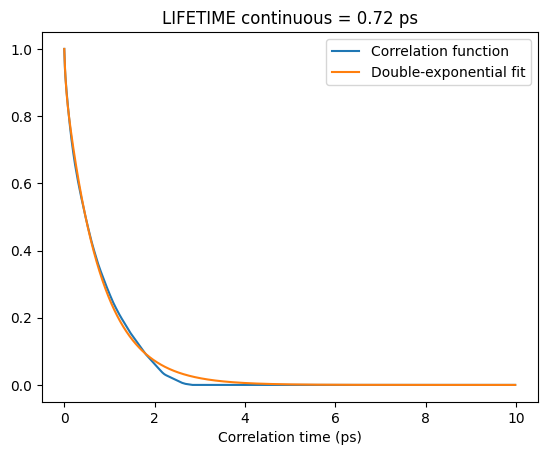

In [92]:
from common import tcf2df
fit_and_plot_double_exp(tcf2df("continuous_hydroxide_lifetime.txt"), title="continuous");

A=0.06 tau1=0.02 tau2=1.90 lifetime=1.78


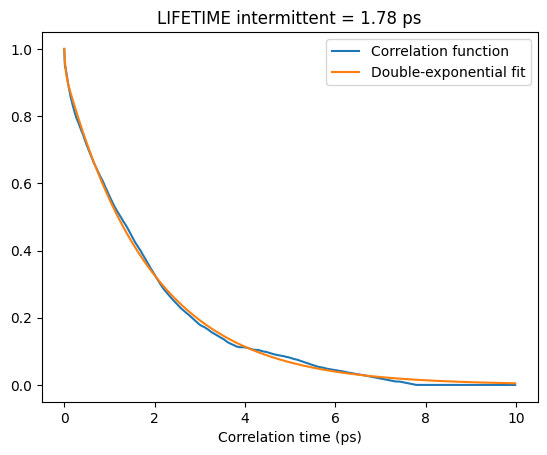

In [93]:
fit_and_plot_double_exp(tcf2df("intermittent_hydroxide_lifetime.txt"), title="intermittent");

## Lifetime from SSP: Stable States Picture

The SSP time correlation function gives the probability that a *clear* hydroxide O at time t_0 has NOT become a *clear* water O at time t_0+deltaT.

In [94]:
%%sh
cat > hydroxide3.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup DefiniteO_H(AllCN) BOND O H MaxDist 1.1 MinCoord 0
DefineGroup ExclusionO_H BOND O H MinDist 1.1 MaxDist 1.4 Coord 0

# The reactant DefiniteHydroxideO should coordinate 
# exactly 1 H within 1.1 angstrom and no other H within 1.4 angstrom
DefineGroup DefiniteO_H(CN1) SUBGROUPCN DefiniteO_H(AllCN) Coord 1
DefineGroup DefiniteHydroxideO INTERSECTION DefiniteO_H(CN1) ExclusionO_H

# If you know that the product is a water molecule, you could use a similar definition for the product:
# DefiniteWaterO should coordinate 2 H within 1.1 angstrom and no other H within 1.4 angstrom
# DefineGroup DefiniteO_H(CN2) SUBGROUPCN DefiniteO_H(AllCN) Coord 2
# DefineGroup DefiniteWaterO INTERSECTION DefiniteO_H(CN2) ExclusionO_H

# However, in the general lifetime case, it's better to define something that is "definitely not hydroxide O"
# which is simply something that coordinates 0, 2, 3, ... hydrogens within 1.1 angstrom:
DefineGroup DefinitelyNotHydroxideO DIFF O DefiniteO_H(CN1)

# see documentation for details - for SSP the "ValueEscape" lines should be set exactly as below
# MaxHistory 10 RealTime means a maximum correlation time of 10 ps
TResidenceTimeSSP \
    Reactants DefiniteHydroxideO \
    Products DefinitelyNotHydroxideO \
    ParentGroup O \
    Filename ssp_hydroxide_lifetime.txt \
    OldValueEscape1 0 0 0 UR \
    NewValueEscape2! 0 0 0 VR \
    MaxHistory 10 RealTime PrintEvery 2000

EOF
OMP_NUM_THREADS=1 lionanalysis.exe hydroxide3.config > hydroxide3.out

A=0.33 tau1=1.27 tau2=1.27 lifetime=1.27


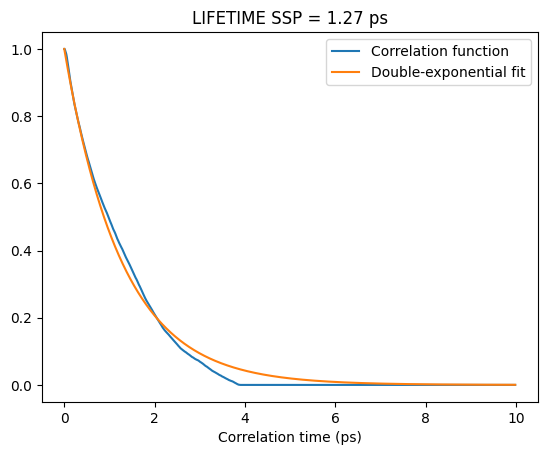

In [95]:
from common import tcf2df
fit_and_plot_double_exp(tcf2df("ssp_hydroxide_lifetime.txt"), title="SSP");

After about 5 ps the correlation function curve has decayed to 0, meaning that ALL *clear* hydroxide ions have turned into *clear* water molecules after at most 5 ps.

To get the lifetime, we can fit this to a double-exponential curve and use the integral under the curve as the estimated lifetime.

This is the exact method that was used in [Hellstrom, Ceriotti, Behler](https://doi.org/10.1021/acs.jpcb.8b06433) - in that paper the life time at this NaOH concentration would be somewhere between 1.33 and 1.74 ps (see Fig. 11). In this tutorial we get a value of 1.27 ps, which is explained by the very short MD simulation in this tutorial (but very thorough ones in the paper).